In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import zipfile
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load data

To understand all features of this dataset, you can read: [code book](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk.htm)

In [10]:
!mkdir ol-data
!wget https://github.com/bahategar/segmentation-UScust2019/raw/main/dataset/scfp2019.zip -P ./ol-data/

mkdir: cannot create directory ‘ol-data’: File exists
--2022-09-28 16:51:36--  https://github.com/bahategar/segmentation-UScust2019/raw/main/dataset/scfp2019.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bahategar/segmentation-UScust2019/main/dataset/scfp2019.zip [following]
--2022-09-28 16:51:36--  https://raw.githubusercontent.com/bahategar/segmentation-UScust2019/main/dataset/scfp2019.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2635565 (2.5M) [application/zip]
Saving to: ‘./ol-data/scfp2019.zip.1’

scfp2019.zip.1      100%[===================>]   2.51M  --.-KB/s    in 0.06s   



In [11]:
# Load dataset

with zipfile.ZipFile('/content/ol-data/scfp2019.zip') as z:
  with z.open('SCFP2019.csv') as f:
    df = pd.read_csv(f, encoding="ISO-8859-1")

df.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


For this project, we're going to focung on households that have "been turned down for credit or feared being denied credit in the past 5 years." and have net worth less than 3 million.

According to reference of dataset, TURNFEAR column represent household that has been turned down for credit or feared being deined credit in the past 5 years with label:
- yes: 1
- no: 0

In [12]:
# slicing dataset that have TURNFEAR value 1
df_fear = df[(df["TURNFEAR"] == 1) & (df['NETWORTH'] < 3e6)]
print('df_fear shape: {}'.format(df_fear.shape))
df_fear.head()

df_fear shape: (4458, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


# Explore

## Age

In [13]:
age_groups = df_fear['AGECL'].unique()
age_groups

array([3, 5, 1, 2, 4, 6])

According to reference, AGECL is age group of the reference person with label and value:
- 1; label < 35
- 2; label 35-44
- 3; label 45-54
- 4; label 55-64
- 5; label 65-74
- 6; label >= 75

In [14]:
age_group = {1: 'Under 35', 
             2: '35-44',
             3: '45-54',
             4: '55-64',
             5: '65-74',
             6: '75 or older'}

df_agecl_fear = df_fear['AGECL'].replace(age_group).value_counts()
df_agecl_fear = pd.DataFrame({'TURNFEAR': [1 for i in range (len(df_agecl_fear))],
                              'AGECL': list(df_agecl_fear.index),
                              'frequency':list(df_agecl_fear.values)})
df_agecl_nofear = df[df['TURNFEAR'] == 0]
df_agecl_nofear = df_agecl_nofear['INCCAT'].replace(age_group).value_counts()
df_agecl_nofear = pd.DataFrame({'TURNFEAR': [0 for i in range(len(df_agecl_nofear))],
                                'AGECL': list(df_agecl_nofear.index),
                                'frequency':list(df_agecl_nofear.values)})

age_cl = pd.concat([df_agecl_nofear, df_agecl_fear], axis=0, ignore_index=True)


age_cl.head()

,TURNFEAR,AGECL,frequency
0,0,75 or older,7213
1,0,55-64,4242
2,0,45-54,3473
3,0,Under 35,3405
4,0,35-44,3298


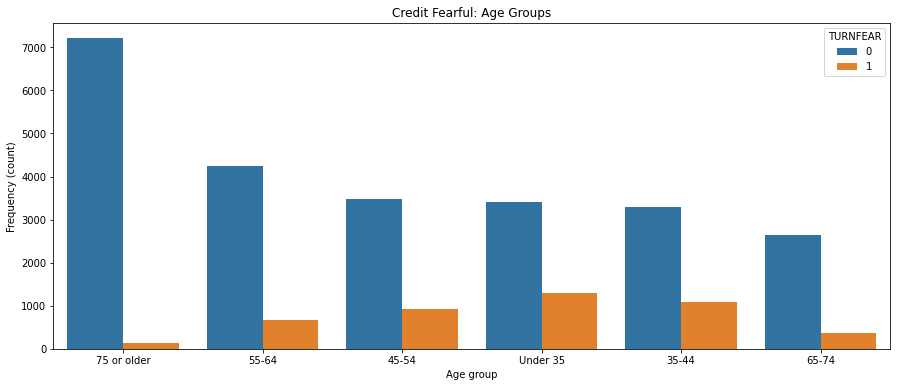

In [15]:
plt.figure(figsize=(15,6))
sns.barplot(data=age_cl, x='AGECL', y='frequency', hue='TURNFEAR')
plt.title('Credit Fearful: Age Groups')
plt.xlabel('Age group')
plt.ylabel('Frequency (count)')
plt.show()

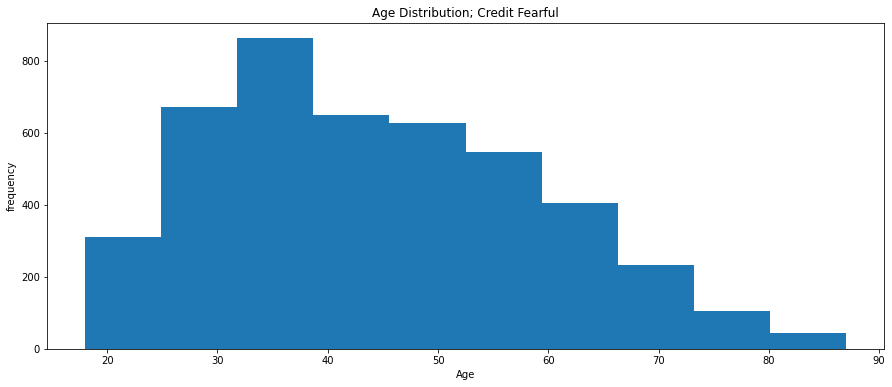

In [16]:
plt.figure(figsize=(15,6))
plt.title('Age Distribution; Credit Fearful')
df_fear['AGE'].plot.hist(bins=10)
plt.xlabel('Age')
plt.ylabel('frequency')
plt.show()

## Race


In [17]:
race_groups = df_fear['RACE'].unique()
race_groups

array([1, 3, 2, 5])

According to the reference of database:
- 1: white non-Hispanic
- 2: black/African American
- 3: Hispanic
- 5: Other

In [18]:
race_groups = {1:'White non-Hispanic',
               2:'Black/African American',
               3: 'Hispanic',
               5: 'Other'}

race_cl = df_fear['RACE'].replace(race_groups)

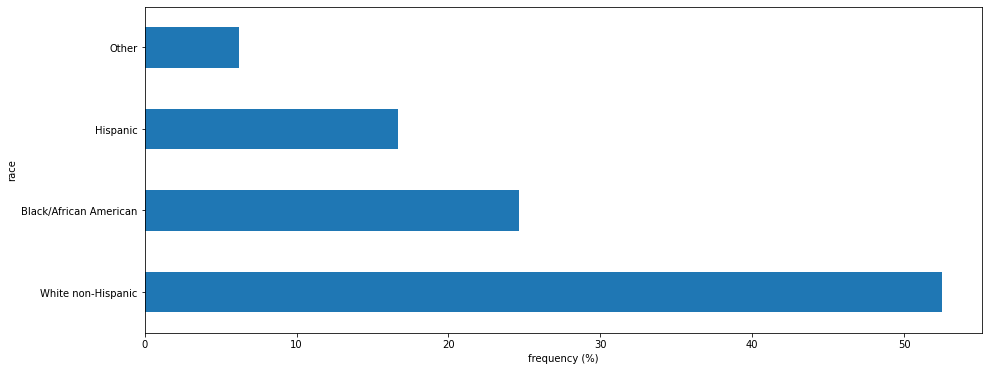

In [19]:
plt.figure(figsize=(15, 6))
(race_cl.value_counts(normalize=True) * 100).plot(kind='barh')
plt.xlabel('frequency (%)')
plt.ylabel('race')
plt.show()

Notes: The 2020 U.S. Census shows that more than 50% of populations in U.S. is white people ( [reference](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States) ), so it make sense that the highest of frequency than others.

## Background

According to the reference of database:

- -1: Less than 1st grade
- 1: 1st, 2nd, 3rd, or 4th grade
- 2: 5th or 6th grade
- 3: 7th or 8th grade
- 4: 9th grade
- 5: 10th grade
- 6: 11th grade
- 7: 12th grade
- 8: High school graduate - high school diploma or equivalent
- 9: Some college but no degree
- 10: Associate degree in college - occupation/vocation program
- 11: Associate degree in college - academic program
- 12: Bachelor's degree
- 13: Master's degree
- 14: Doctorate or professional school degree

In [20]:
df_educ_fear = df_fear['EDUC'].value_counts(normalize=True)
df_educ_fear = pd.DataFrame({'TURNFEAR':[1 for i in range(len(df_educ_fear))],
                              'EDUC':list(df_educ_fear.index),
                              'frequency':list(df_educ_fear.values)})
df_educ_nofear = df[df['TURNFEAR'] == 0]
df_educ_nofear = df_educ_nofear['EDUC'].value_counts(normalize=True)
df_educ_nofear = pd.DataFrame({'TURNFEAR':[0 for i in range(len(df_educ_nofear))],
                              'EDUC':list(df_educ_nofear.index),
                              'frequency':list(df_educ_nofear.values)})
educ_groups = {-1:'< 1st grade',
               1: '1st, 2nd, 3rd, or 4th grade',
               2: '5th or 6th grade',
               3: '7th or 8th grade',
               4: '9th grade',
               5: '10th grade',
               6: '11th grade',
               7: '12th grade',
               8: 'High schoold graduate',
               9: 'Some college (no degree)',
               10: 'Vocation program',
               11: 'Academic program',
               12: 'Bachelor degree',
               13: 'Master degree',
               14: 'Doctorate degree'}
df_educ = pd.concat([df_educ_nofear, df_educ_fear], axis=0, ignore_index=True)
df_educ['EDUC'] = df_educ['EDUC'].replace(educ_groups)

df_educ.head()

,TURNFEAR,EDUC,frequency
0,0,Bachelor degree,0.257481
1,0,High schoold graduate,0.192029
2,0,Master degree,0.149823
3,0,Some college (no degree),0.129833
4,0,Doctorate degree,0.096117


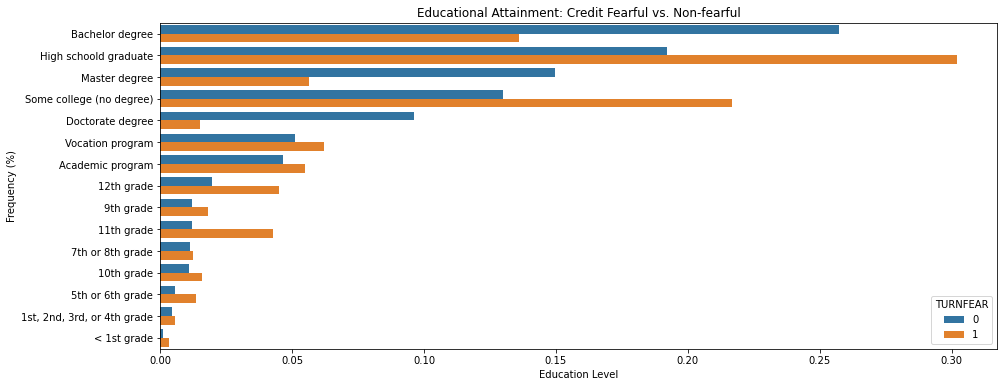

In [21]:
plt.figure(figsize=(15,6))
sns.barplot(data=df_educ, y='EDUC', x='frequency', hue="TURNFEAR")
plt.xlabel("Education Level")
plt.ylabel("Frequency (%)")
plt.title("Educational Attainment: Credit Fearful vs. Non-fearful");

## Assets and Debt

In [22]:
cols = ['ASSET', 'HOUSES', 'INCOME', 'DEBT']
corr = df_fear[cols].corr()
corr.style.background_gradient(axis=None)

,ASSET,HOUSES,INCOME,DEBT
ASSET,1.000000,0.796078,0.592485,0.666234
HOUSES,0.796078,1.000000,0.464240,0.702564
INCOME,0.592485,0.464240,1.000000,0.574042
DEBT,0.666234,0.702564,0.574042,1.000000


<Figure size 1080x432 with 0 Axes>

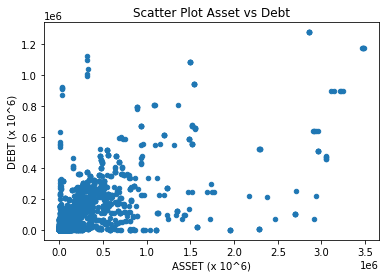

In [23]:
# Scatter plot ASSET vs DEBT
plt.figure(figsize=(15, 6))
df_fear[['ASSET','DEBT']].plot(kind='scatter', x='ASSET', y='DEBT')
plt.title('Scatter Plot Asset vs Debt')
plt.xlabel('ASSET (x 10^6)')
plt.ylabel('DEBT (x 10^6)')
plt.show()

<Figure size 1080x432 with 0 Axes>

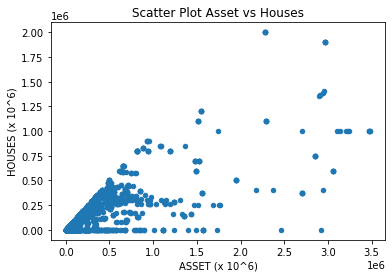

In [24]:
# Scatter plot ASSET vs HOUSES
plt.figure(figsize=(15, 6))
df_fear[['ASSET','HOUSES']].plot(kind='scatter', x='ASSET', y='HOUSES')
plt.title('Scatter Plot Asset vs Houses')
plt.xlabel('ASSET (x 10^6)')
plt.ylabel('HOUSES (x 10^6)')
plt.show()

<Figure size 1080x432 with 0 Axes>

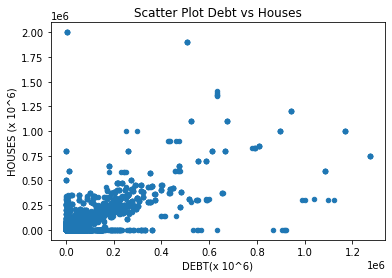

In [25]:
# Scatter plot ASSET vs HOUSES
plt.figure(figsize=(15, 6))
df_fear[['DEBT','HOUSES']].plot(kind='scatter', x='DEBT', y='HOUSES')
plt.title('Scatter Plot Debt vs Houses')
plt.xlabel('DEBT(x 10^6)')
plt.ylabel('HOUSES (x 10^6)')
plt.show()

## Top 5 Features with the Largest Variance

In [26]:
top_five_feat = df_fear.apply(trimmed_var, limits=(0.15, 0.15)).sort_values(ascending=False).head(5)

fig = px.bar(x=top_five_feat, y=top_five_feat.index, orientation='h', title='Top 5 High Variance Features')
fig.update_layout(xaxis_title='Variance', yaxis_title='Features')
fig.show()

# Building Model

In [27]:
X = df_fear[top_five_feat.index]
X.describe().loc[['mean','std']]

,ASSET,NFIN,HOUSES,DEBT,NETWORTH
mean,173846.537236,135538.796546,83517.743383,76476.321220,97370.216016
std,388708.458176,312711.011757,189622.551462,145526.176485,311284.564233


In [28]:
# standardization
scaler = StandardScaler()

# transform data
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.describe().loc[['mean', 'std']]

,ASSET,NFIN,HOUSES,DEBT,NETWORTH
mean,4.781580e-17,1.434474e-17,-9.563159e-18,-5.100352e-17,3.506492e-17
std,1.000112e+00,1.000112e+00,1.000112e+00,1.000112e+00,1.000112e+00


In [29]:
# Parameter tunning
n_clusters = range(2, 10)
inertia_error = list()
silhouette_scores = list()

for i in n_clusters:
  # create model
  model = make_pipeline(StandardScaler(), KMeans(n_clusters=i, random_state=42))
  # fitting
  model.fit(X)
  # calculate measurement error
  inertia_error.append(model[-1].inertia_)
  silhouette_scores.append(silhouette_score(X, model[-1].labels_))


In [30]:
# create line plot of inertia error vs n_cluster
fig = px.line(x=n_clusters, y=inertia_error, title='Inertia vs Number of Clusters')
fig.update_layout(xaxis_title='number of clusters', yaxis_title='inertia')
fig.show()

In [31]:
# create line plot of inertia error vs n_cluster
fig = px.line(x=n_clusters, y=silhouette_scores, title='Silhouette score vs Number of Clusters')
fig.update_layout(xaxis_title='number of clusters', yaxis_title='silhouette score')
fig.show()

In [32]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [33]:
labels = final_model[-1].labels_
result = X.groupby(labels).mean()
result

,ASSET,NFIN,HOUSES,DEBT,NETWORTH
0,4.876228e+05,3.951333e+05,286674.721190,232326.301115,2.552965e+05
1,2.219439e+06,1.728405e+06,816700.000000,540384.400000,1.679055e+06
2,4.493165e+04,3.168653e+04,16701.098282,27993.713039,1.693794e+04


In [34]:
fig = px.bar(result, barmode='group')
fig.show()

In [35]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

fig = px.scatter(data_frame=X_pca,
                 x='PC1',
                 y='PC2',
                 color=labels.astype(str),
                 title='PCA representation')

fig.show()